<a href="https://colab.research.google.com/github/mzawadzki90/kickstarter_project/blob/master/spotify_v4_no_word_embedding(2022_01_04).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# modules we'll use
from collections import Callable

import numpy as np
import pandas as pd
import gensim
import tensorflow as tf
import sys, os, datetime

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from datetime import datetime

# Load the TensorBoard notebook extension
% load_ext tensorboard

#mount Google Drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.insert(0, '/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/code')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mounted at /content/drive


In [54]:
# load own modules
from genetic_algorithm.crossover import OnePointCrossover
from genetic_algorithm.gene import FloatGene, Gene, IntegerGene
from genetic_algorithm.genetic_algorithm import GeneticAlgorithm
from genetic_algorithm.genome import Genome, LabeledSequence
from genetic_algorithm.initialization import RandomInitialization
from genetic_algorithm.mutation import CreepNonuniformMutation
from genetic_algorithm.parent_selection import TournamentSelection
from genetic_algorithm.survivor_selection import NoSelection
from plotting.histogram_plotter import HistogramPlotter
from plotting.real_multi_pred_plotter import RealMultiPredPlotter
from preprocessing.label_binarizer import DataFrameLabelBinarizer

In [55]:
# read in all our data
# Google Drive's path: /content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/data/spotify.csv
spotify_orig = pd.read_csv('/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/data/spotify.csv')
# set seed for reproducibility
np.random.seed(0)

In [56]:
# look at a few rows of the Spotify dataset file
spotify_orig.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
107349,0.817,2013,0.015800,['Parmalee'],0.551,214933,0.863,0,3Bdqlr7jQLNhITAgcBGQBG,0.0000,11,0.0843,-3.506,1,Close Your Eyes,50,2013-12-10,0.0322,143.952
16271,0.548,2003,0.006610,['JAY-Z'],0.494,234627,0.887,1,7sLpSWxQazJzDVG6YGzlVs,0.0000,6,0.1030,-4.297,0,99 Problems,61,2003-11-14,0.3980,89.554
90972,0.732,2014,0.047700,['Sam Hunt'],0.590,235507,0.940,0,3BuPop8SzLG2Q88TJcFAjp,0.0000,9,0.3790,-4.124,1,Raised On It,54,2014-10-27,0.0409,94.020
84553,0.475,1981,0.000473,['Iron Maiden'],0.340,288947,0.974,0,7EvjTEzuv7TWaIaWY63sWV,0.0928,0,0.3730,-5.114,1,Drifter - 2015 Remaster,29,1981-02-02,0.1060,101.276
75895,0.550,1930,0.994000,"['Markos Vamvakaris', 'Apostolos Xatzixristos']",0.410,197653,0.169,0,38PozVGXXoeO8dTEVzy74Y,0.9010,2,0.1130,-18.862,1,Soultana maurofora,0,1930-01-01,0.0391,93.890


In [57]:
# get info about DataFrame columns
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [58]:
dirname = os.getcwd()
dirname

'/content'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

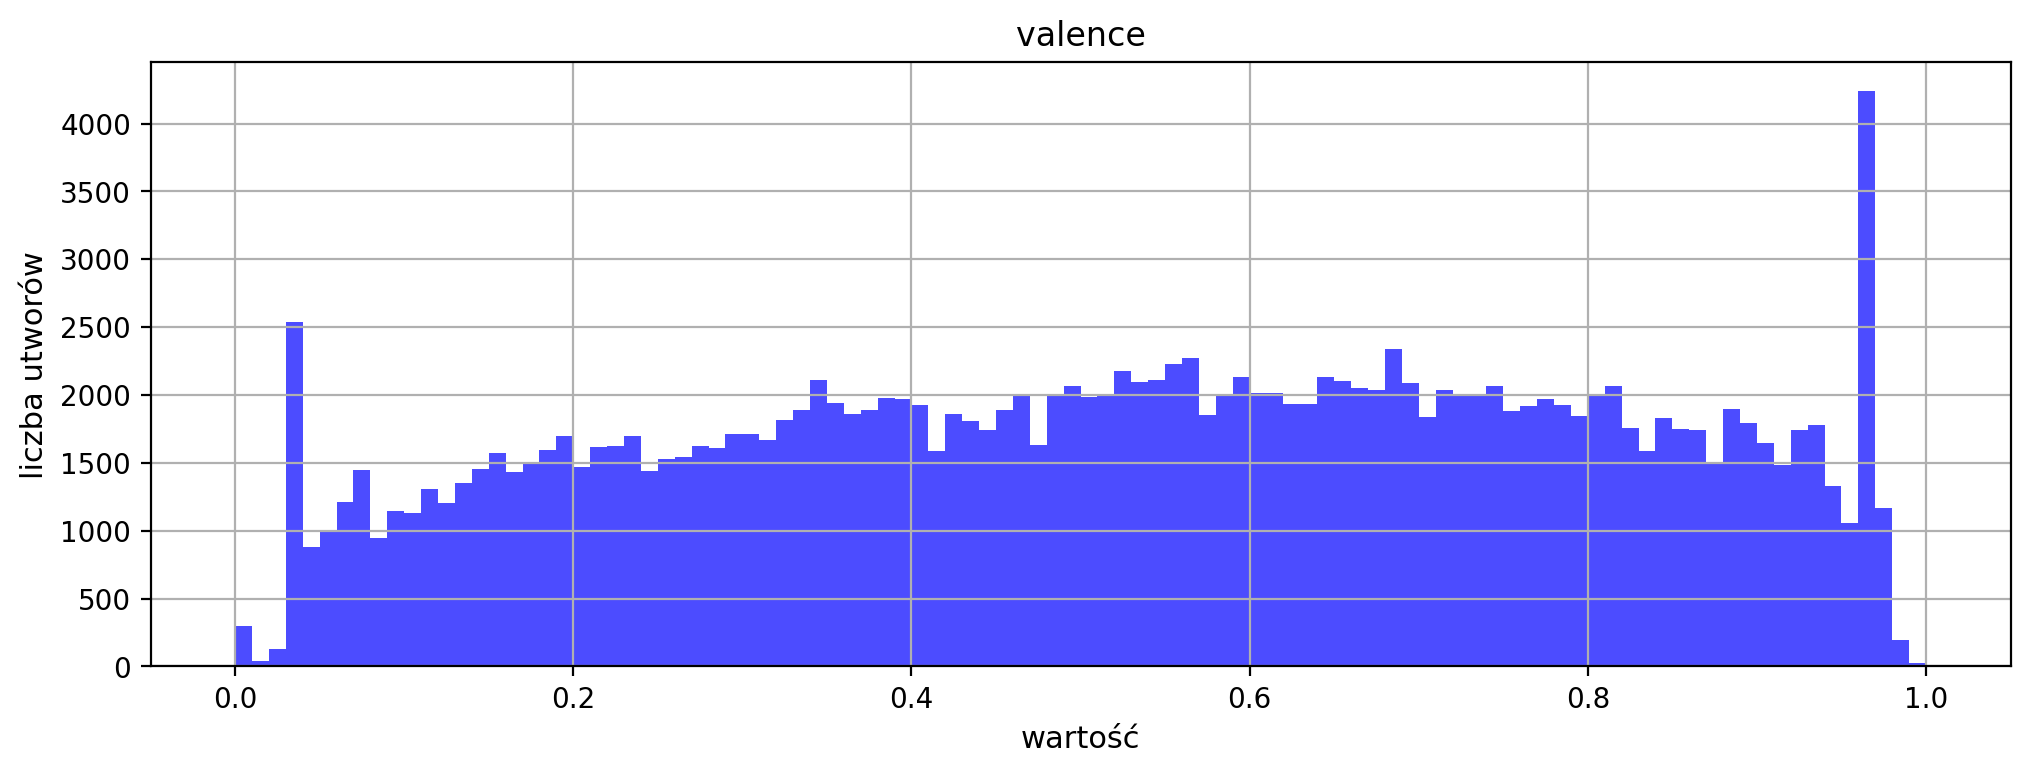

In [59]:
# draw histograms for chosen columns ['valence', 'acousticness', 'danceability', 'duration_ms']
HistogramPlotter(x=spotify_orig['valence'], output_path='plots\\valence.eps').hist(title='valence', xlabel='wartość',
                                                                                   ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

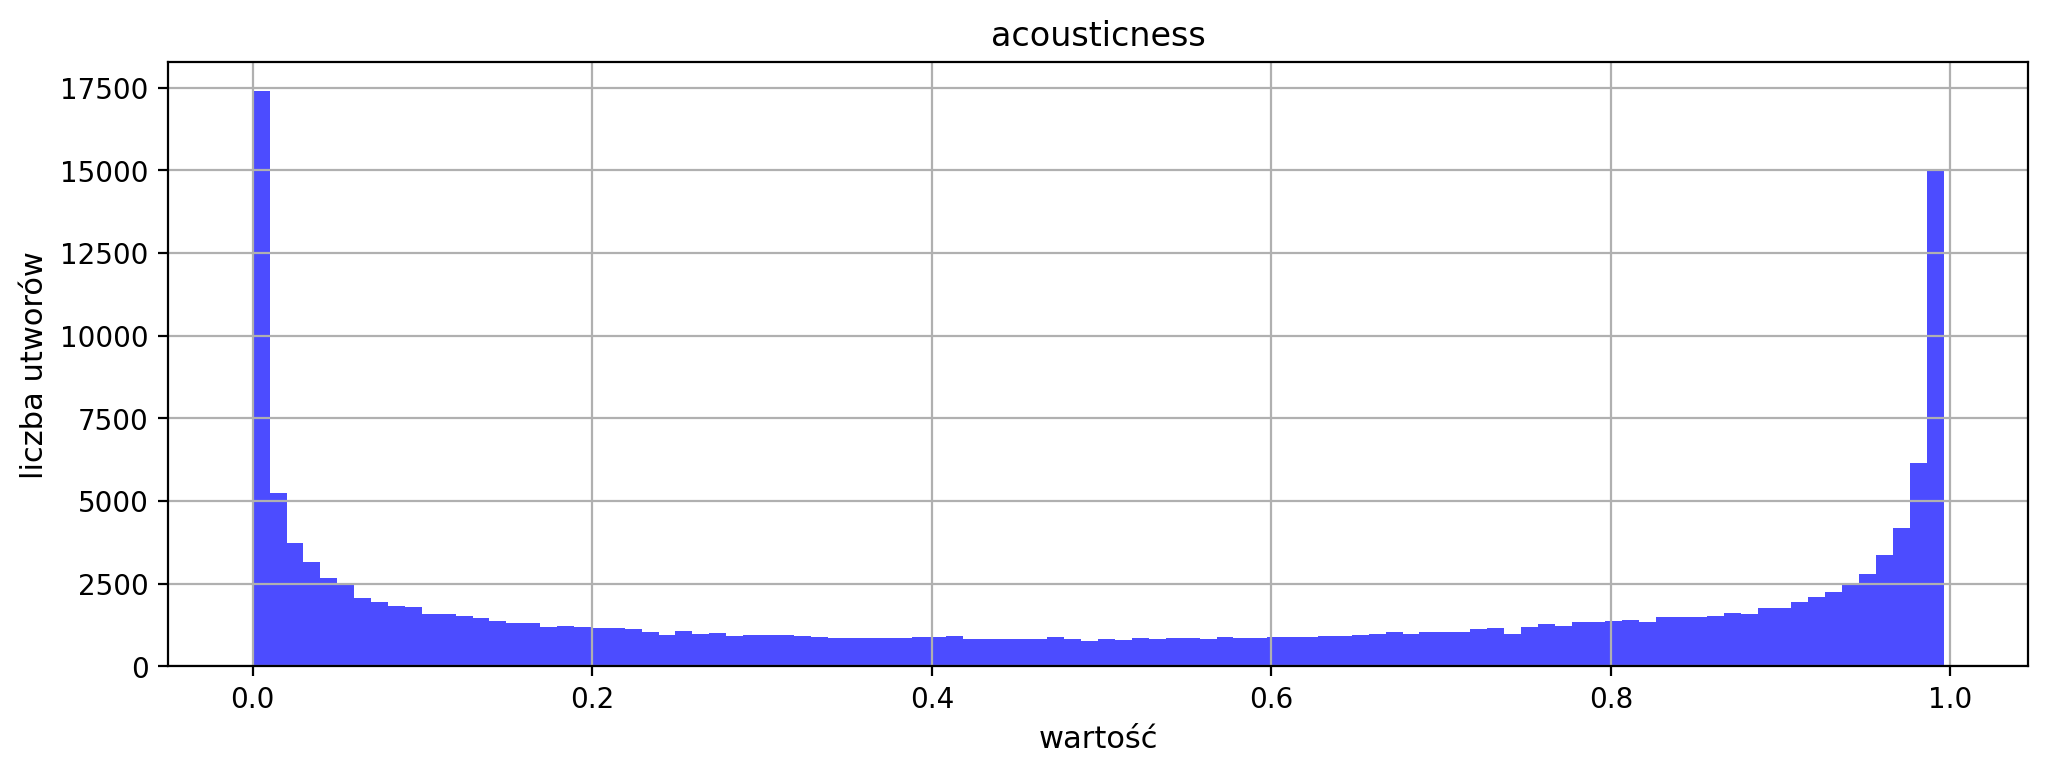

In [60]:
HistogramPlotter(x=spotify_orig['acousticness'], output_path='plots\\acousticness.eps').hist(title='acousticness',
                                                                                             xlabel='wartość',
                                                                                             ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

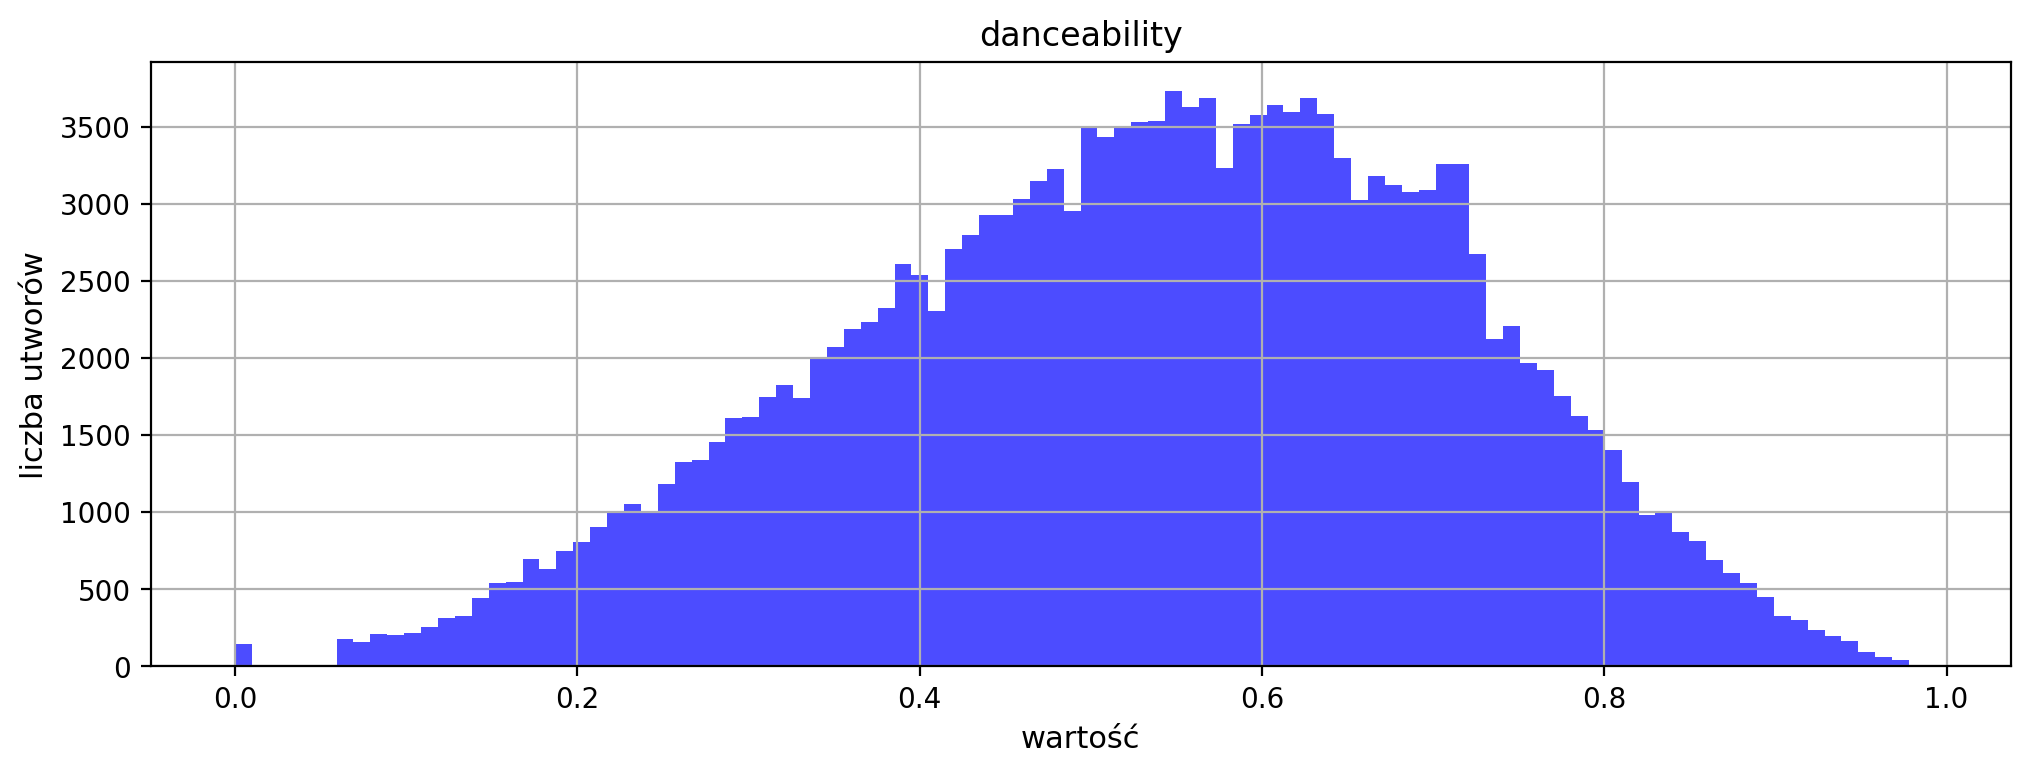

In [61]:
HistogramPlotter(x=spotify_orig['danceability'], output_path='plots\\danceability.eps').hist(title='danceability',
                                                                                             xlabel='wartość',
                                                                                             ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

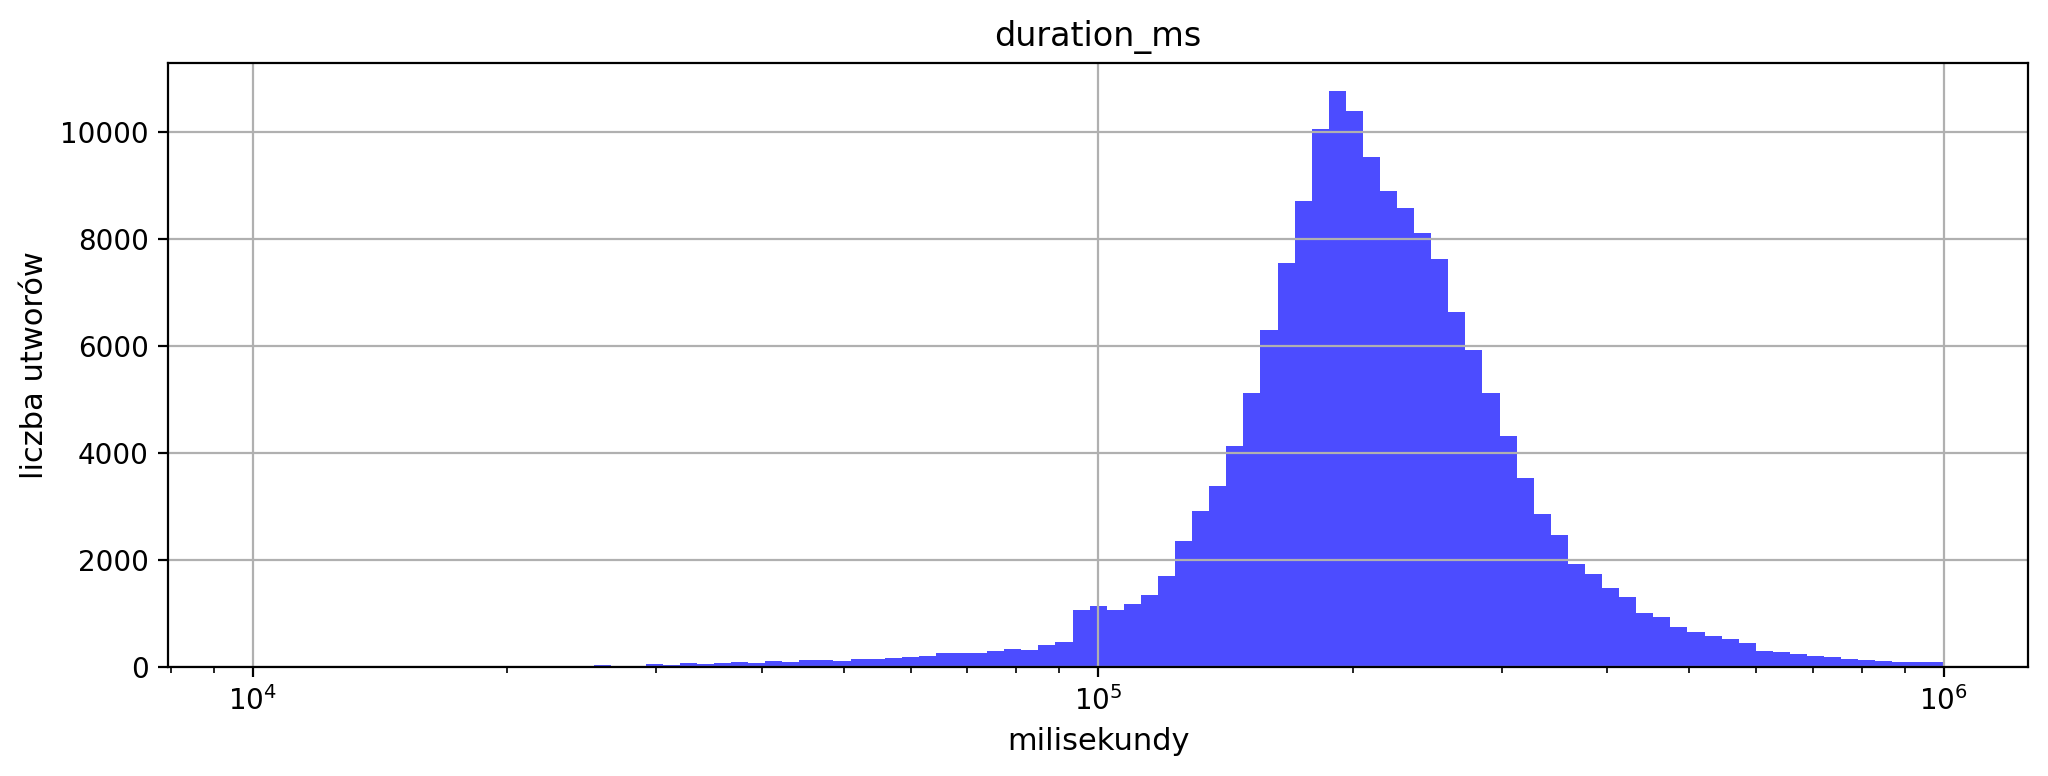

In [62]:
HistogramPlotter(x=spotify_orig['duration_ms'], output_path='plots\\duration_ms.eps').hist(title='duration_ms',
                                                                                           xlabel='milisekundy',
                                                                                           xscale='log', xmin=10 ** 4,
                                                                                           xmax=10 ** 6,
                                                                                           ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

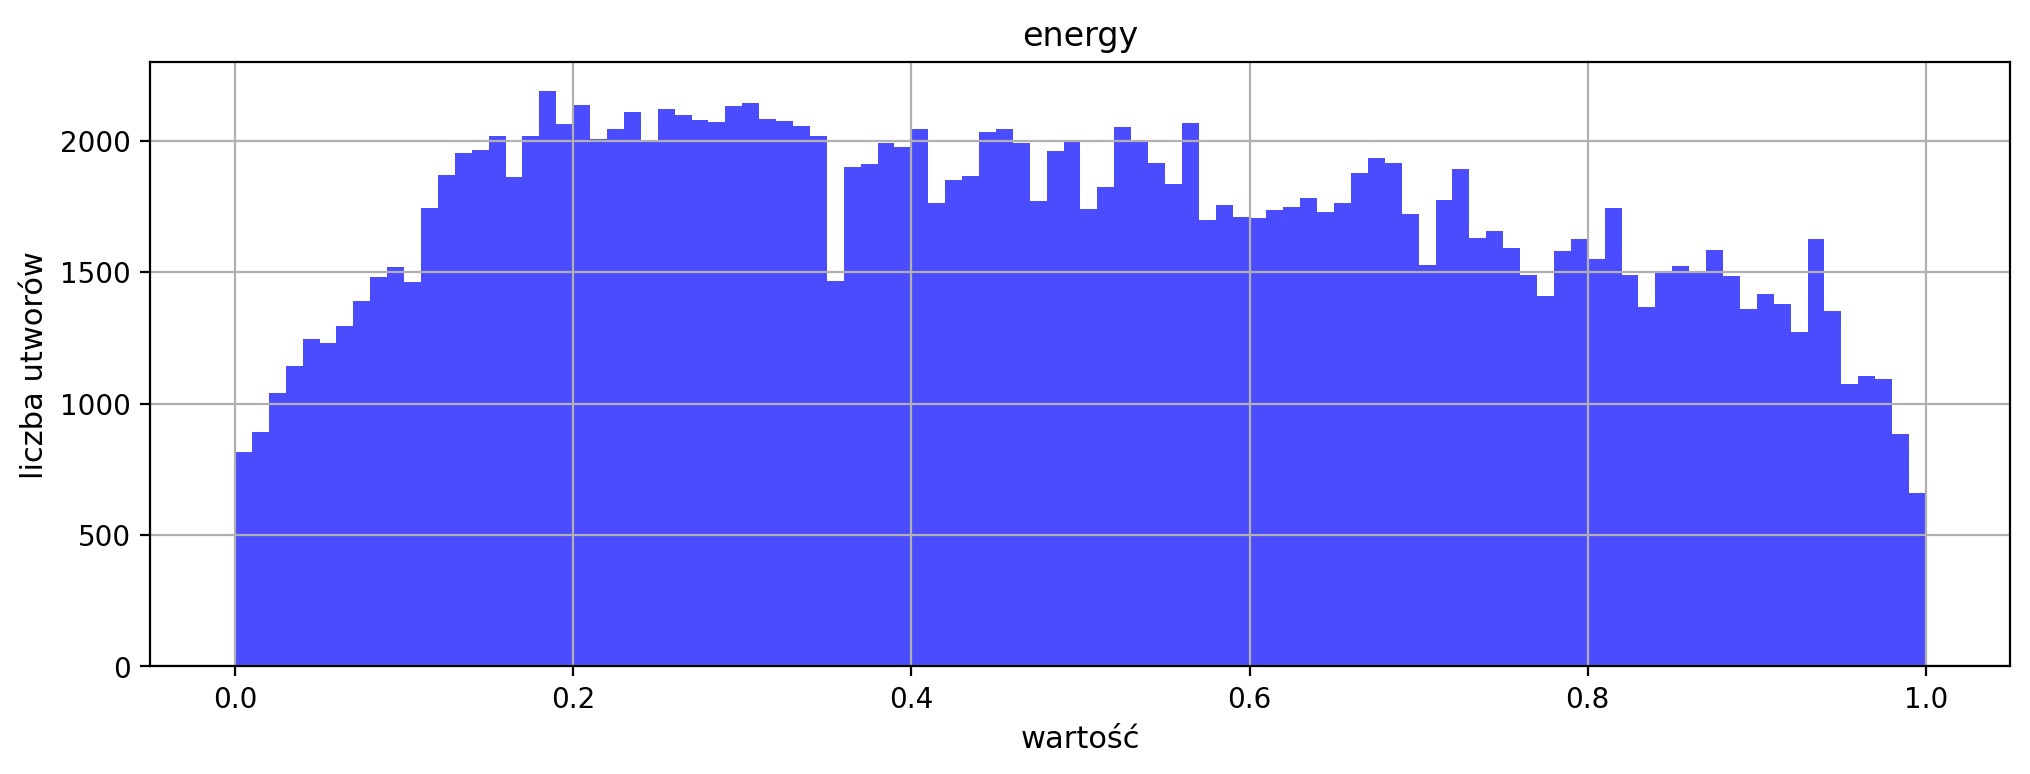

In [63]:
# draw histograms for chosen columns [ 'energy', 'instrumentalness', 'liveness', 'loudness']
HistogramPlotter(x=spotify_orig['energy'], output_path='plots\\energy.eps').hist(title='energy', xlabel='wartość',
                                                                                 ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

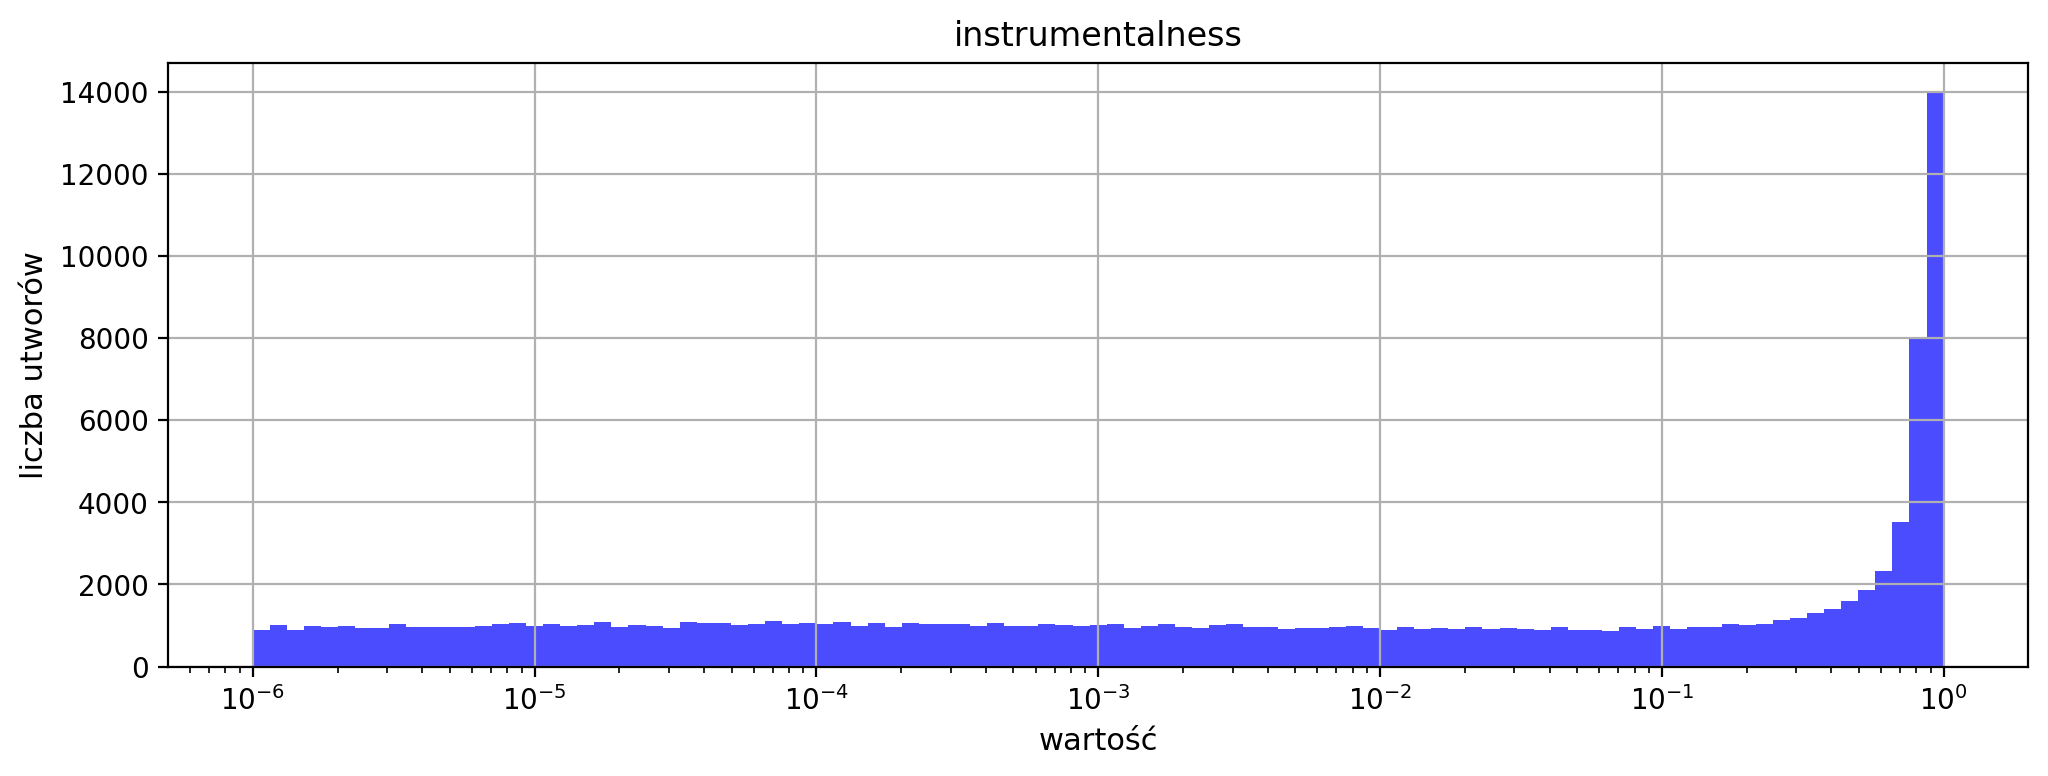

In [64]:
HistogramPlotter(x=spotify_orig['instrumentalness'], output_path='plots\\instrumentalness.eps').hist(
    title='instrumentalness',
    xlabel='wartość',
    xscale='log',
    xmin=10 ** (-6),
    ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

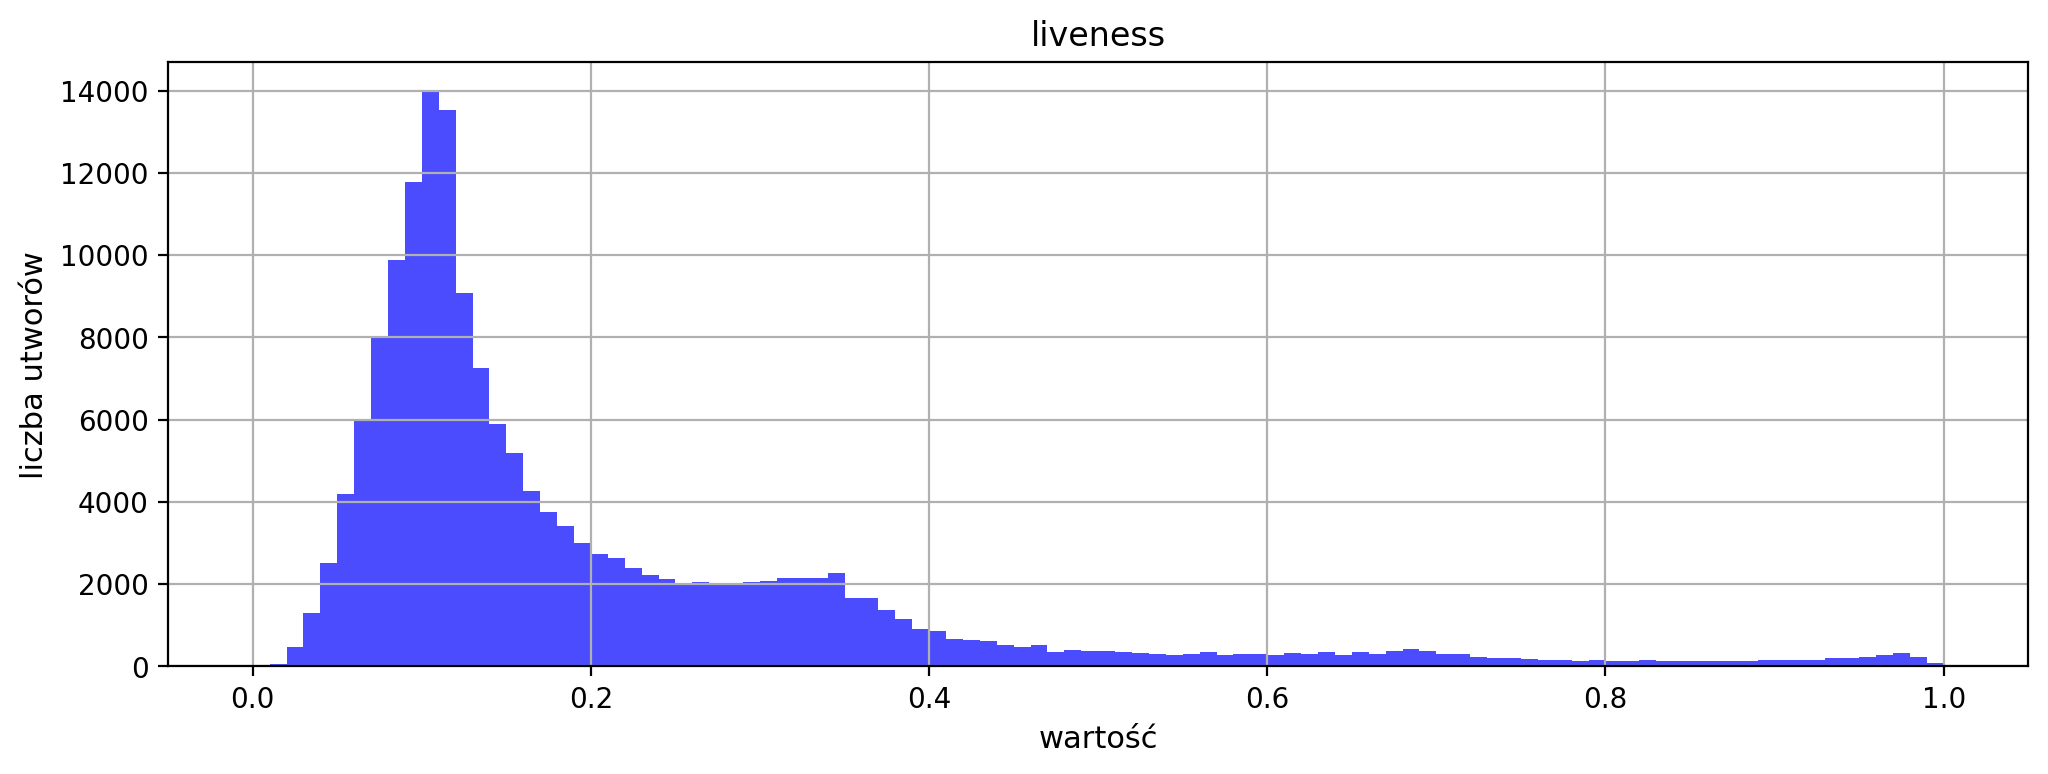

In [65]:
HistogramPlotter(x=spotify_orig['liveness'], output_path='plots\\liveness.eps').hist(title='liveness', xlabel='wartość',
                                                                                     ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

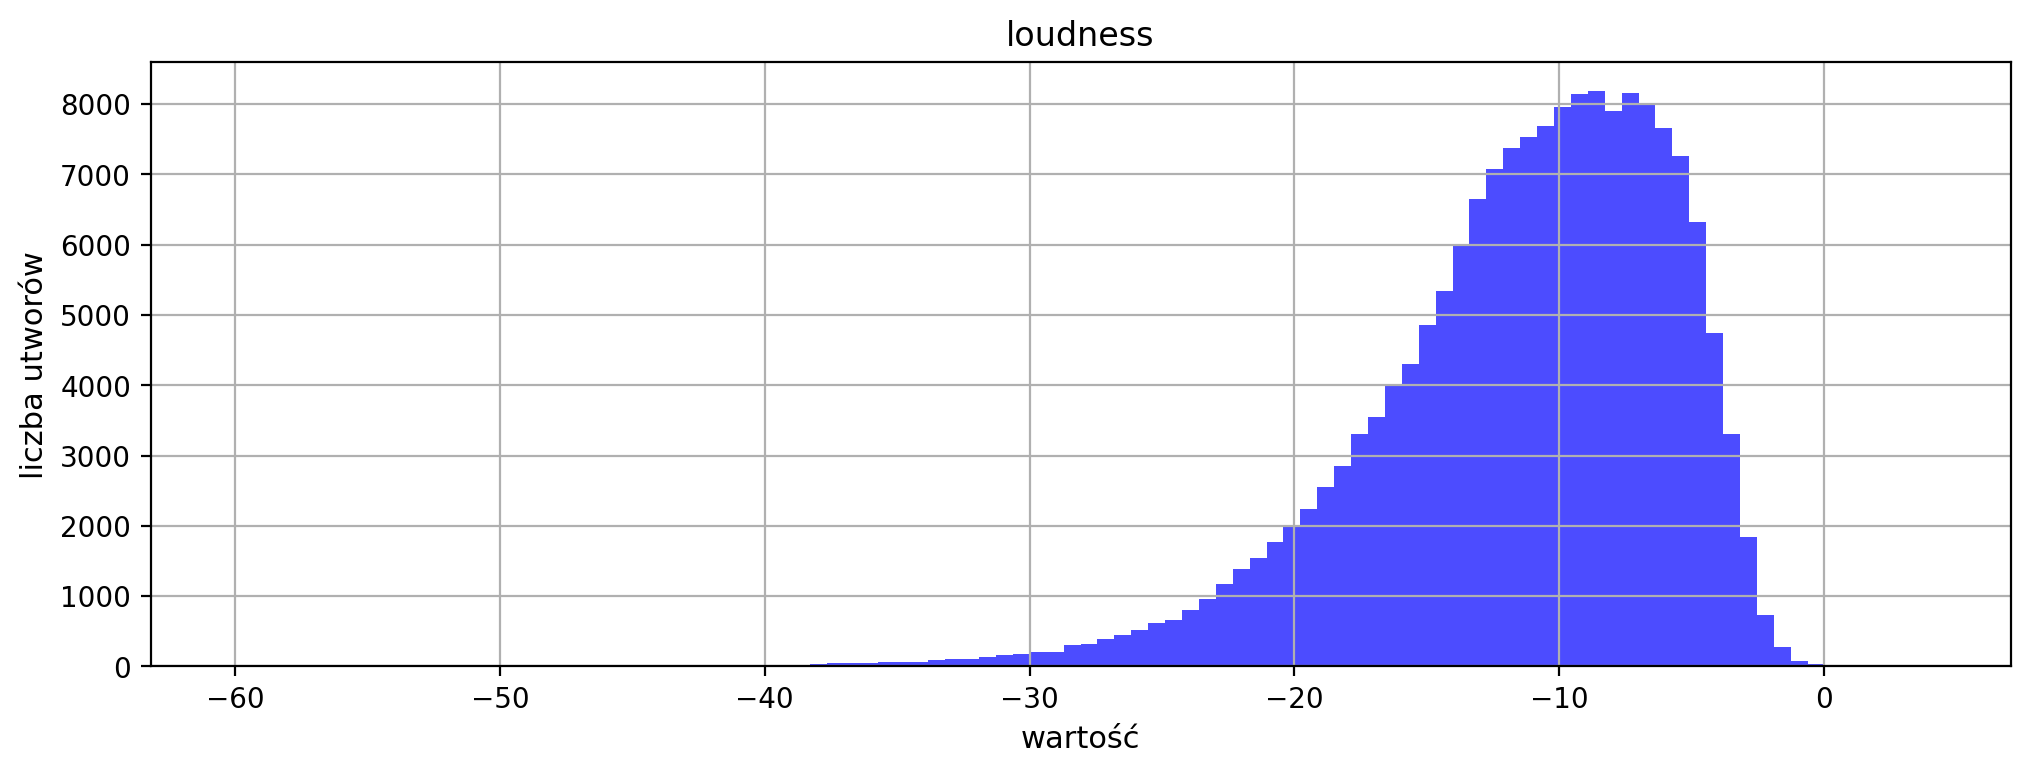

In [66]:
HistogramPlotter(x=spotify_orig['loudness'], output_path='plots\\loudness.eps').hist(title='loudness', xlabel='wartość',
                                                                                     ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

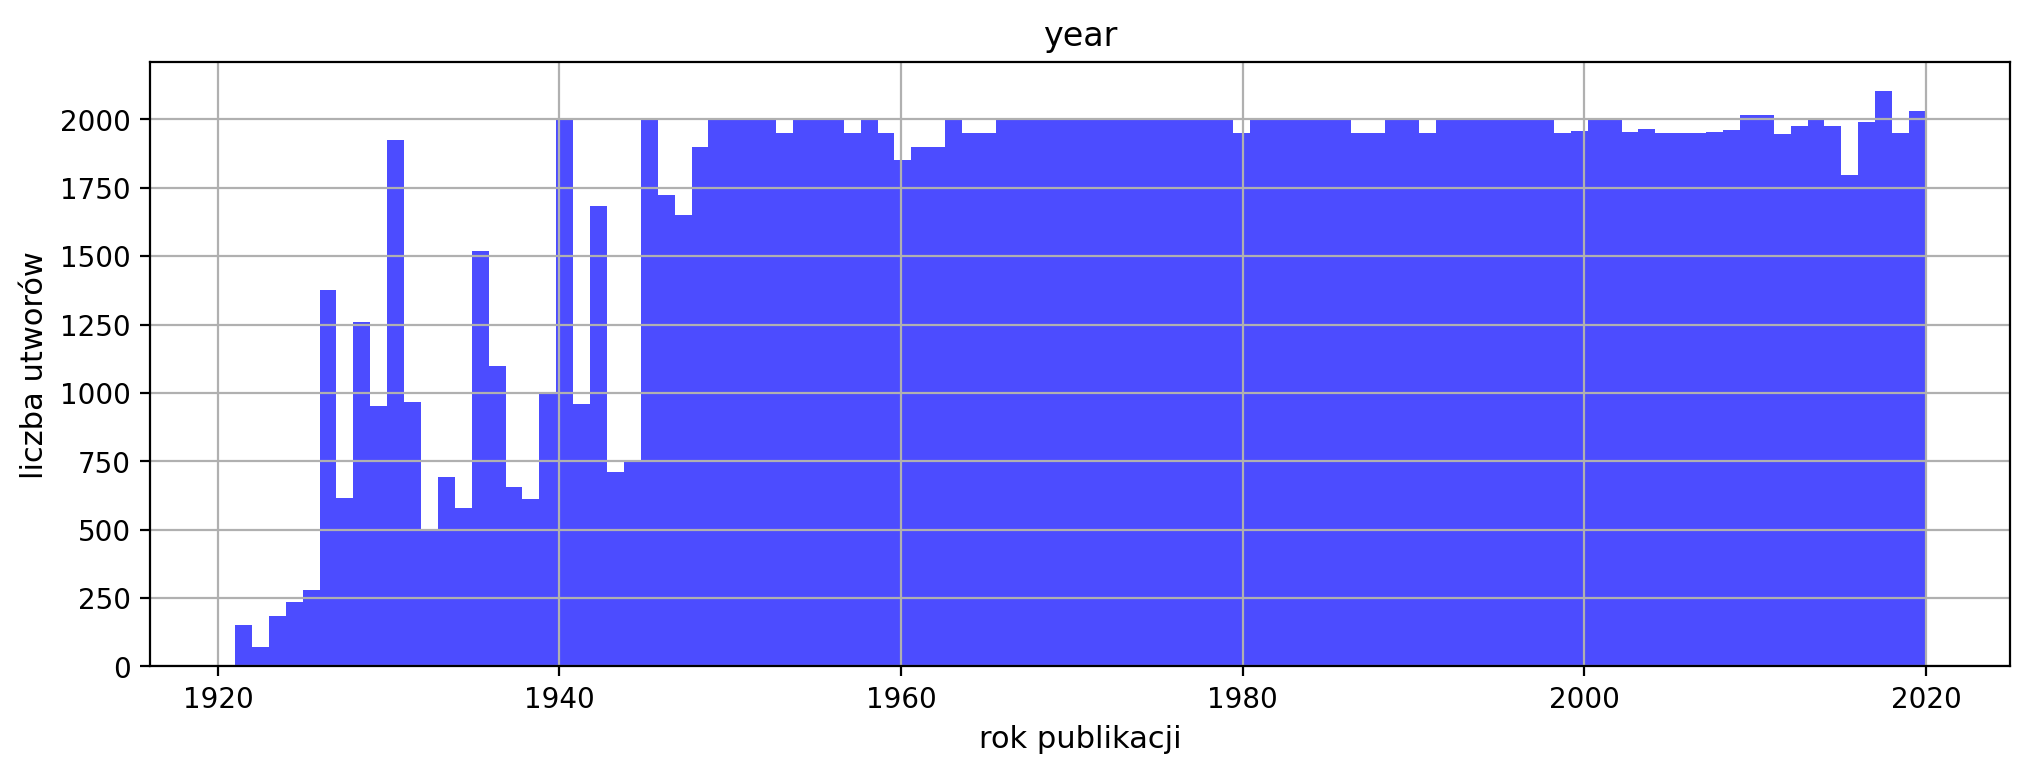

In [67]:
# draw histograms for chosen columns ['year', 'speechiness', 'tempo']
HistogramPlotter(x=spotify_orig['year'], output_path='plots\\year.eps').hist(title='year', xlabel='rok publikacji',
                                                                             ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

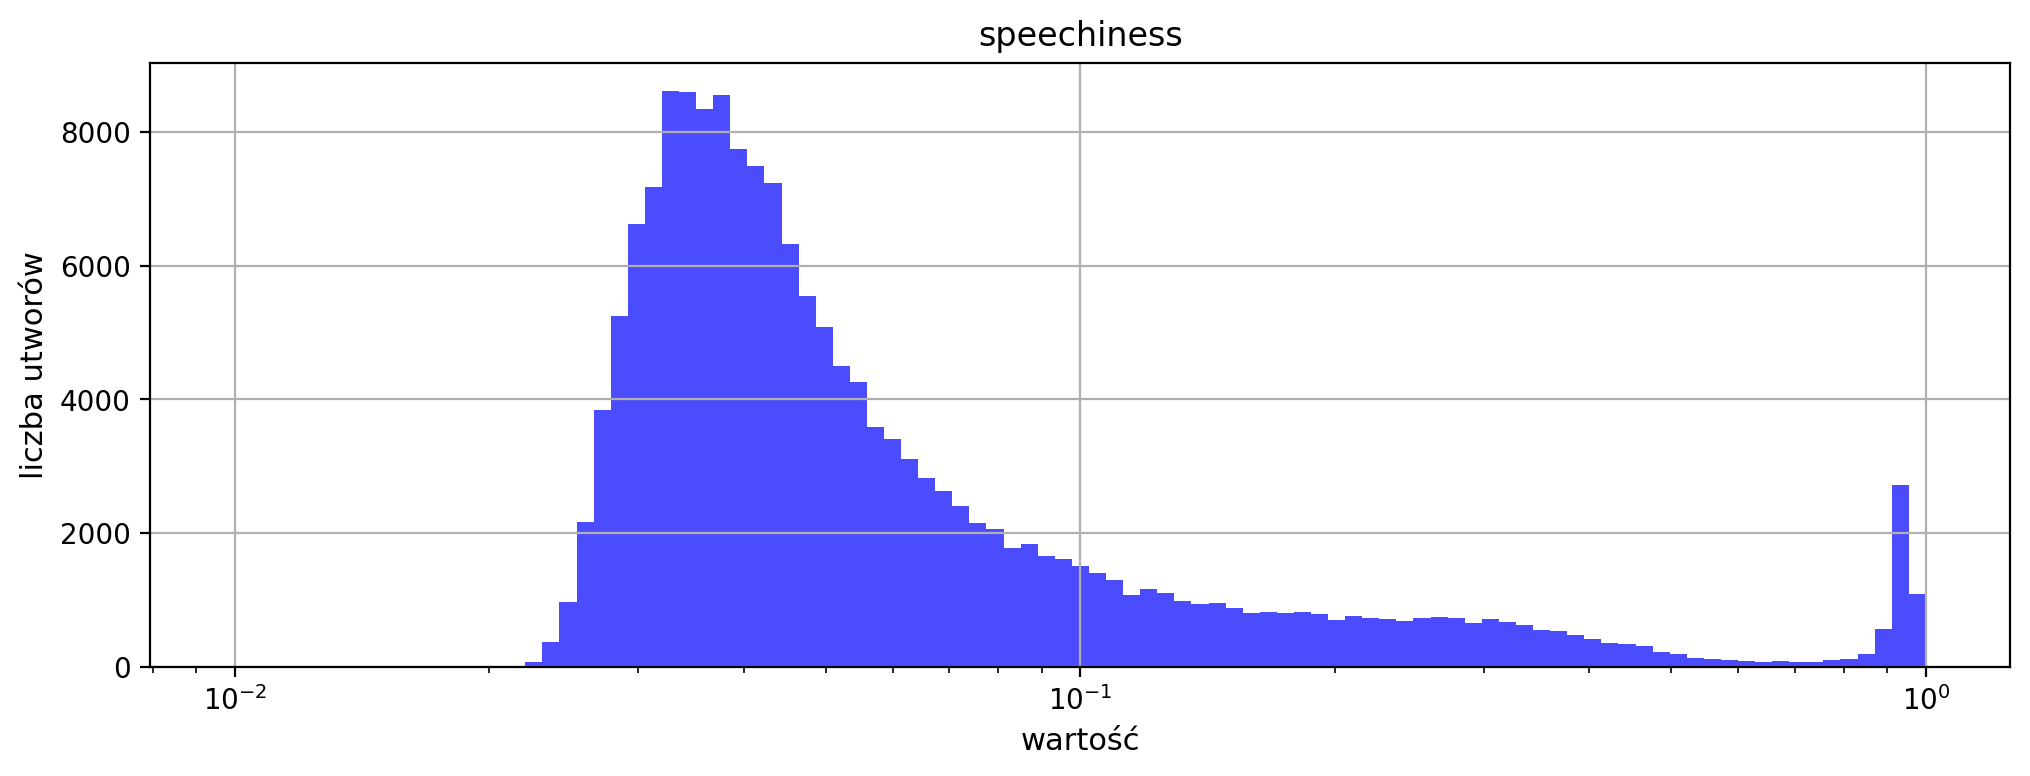

In [68]:
HistogramPlotter(x=spotify_orig['speechiness'], output_path='plots\\speechiness.eps').hist(title='speechiness',
                                                                                           xlabel='wartość',
                                                                                           xscale='log', xmin=0.01,
                                                                                           ylabel='liczba utworów')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

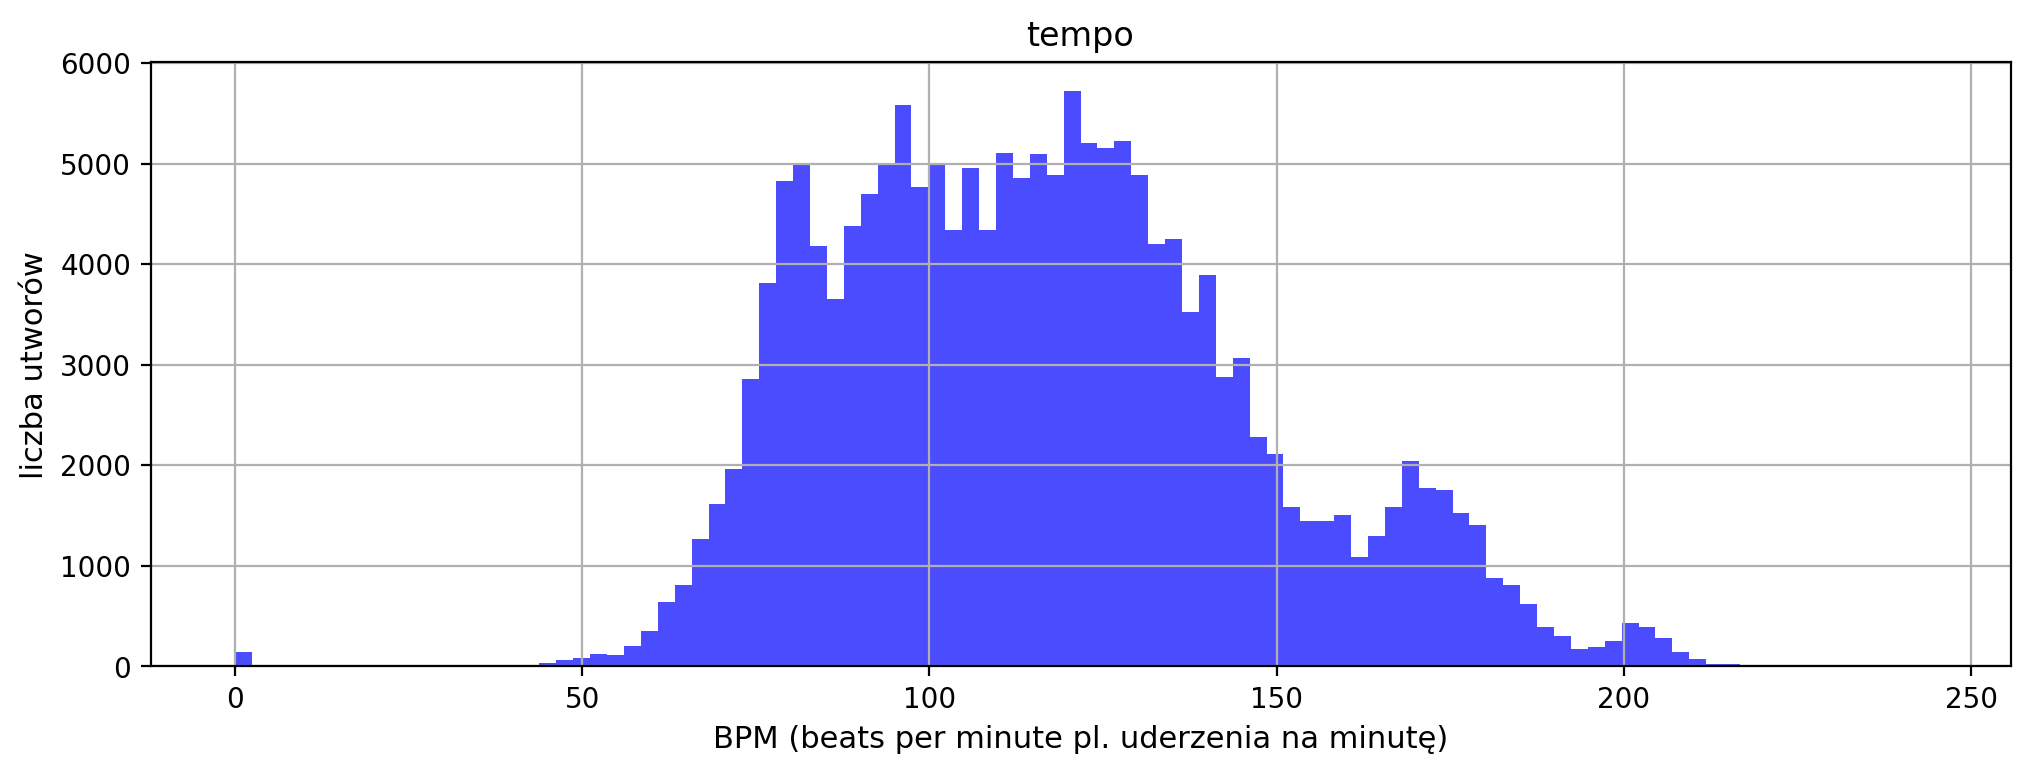

In [69]:
HistogramPlotter(x=spotify_orig['tempo'], output_path='plots\\tempo.eps').hist(title='tempo',
                                                                               xlabel='BPM (beats per minute pl. uderzenia na minutę)',
                                                                               ylabel='liczba utworów')

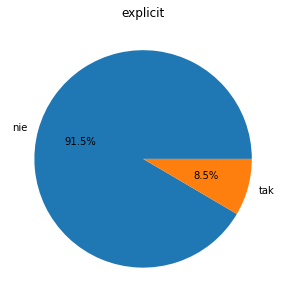

In [70]:
#Draw pie chart for explicit content
explicit_values = pd.DataFrame(spotify_orig['explicit'].value_counts(sort=True).values,
                               index=['nie', 'tak'])
explicit_pie = explicit_values.plot.pie(title='explicit', y=0, ylabel='', legend=False, autopct='%1.1f%%',
                                        figsize=(5, 5))
explicit_pie.get_figure().savefig(os.path.join(dirname, 'plots\\explicit.eps'))

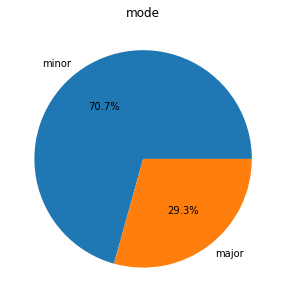

In [71]:
#Draw pie chart for modes
mode_values = pd.DataFrame(spotify_orig['mode'].value_counts(sort=True).values,
                           index=['minor', 'major'])
mode_pie = mode_values.plot.pie(title='mode', y=0, ylabel='', legend=False, autopct='%1.1f%%', figsize=(5, 5))
mode_pie.get_figure().savefig(os.path.join(dirname, 'plots\\mode.eps'))

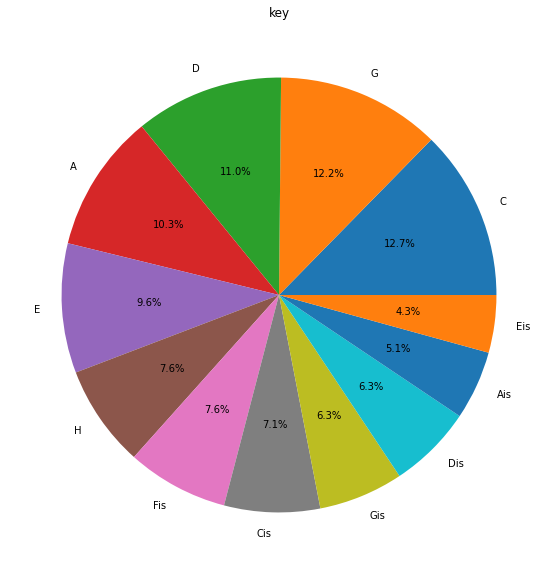

In [72]:
#Draw pie chart for keys
key_values = pd.DataFrame(spotify_orig['key'].value_counts(sort=True).values,
                          index=['C', 'G', 'D', 'A', 'E', 'H', 'Fis', 'Cis', 'Gis', 'Dis', 'Ais', 'Eis'])
key_pie = key_values.plot.pie(title='key', y=0, ylabel='', legend=False, autopct='%1.1f%%', figsize=(10, 10))
key_pie.get_figure().savefig(os.path.join(dirname, 'plots\\key.eps'))

In [73]:
# convert 'key' to one-hot-encoded
lb_category = DataFrameLabelBinarizer(data_frame=spotify_orig, column_to_encode='key')
spotify_converted = lb_category.encode()

In [74]:
# convert release_date to milliseconds
spotify_converted['release_date'] = pd.to_datetime(spotify_converted['release_date'], format="%Y-%m-%d").astype(np.int64) / 10 ** 9

In [75]:
# drop redundant columns
spotify_reduced = spotify_converted.drop(['artists', 'name', 'year', 'id'], axis=1)

In [76]:
# get info about DataFrame columns
spotify_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   acousticness      170653 non-null  float64
 2   danceability      170653 non-null  float64
 3   duration_ms       170653 non-null  int64  
 4   energy            170653 non-null  float64
 5   explicit          170653 non-null  int64  
 6   instrumentalness  170653 non-null  float64
 7   liveness          170653 non-null  float64
 8   loudness          170653 non-null  float64
 9   mode              170653 non-null  int64  
 10  popularity        170653 non-null  int64  
 11  release_date      170653 non-null  float64
 12  speechiness       170653 non-null  float64
 13  tempo             170653 non-null  float64
 14  0                 170653 non-null  int64  
 15  1                 170653 non-null  int64  
 16  2                 17

In [77]:
# look at a few rows of the Spotify dataset
spotify_converted.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,0,1,2,3,4,5,6,7,8,9,10,11
96559,0.6250,1959,0.6820,['Martin Denny'],0.427,142400,0.4110,0,7niPihgrMNksket1T0ZbKa,0.410000,0.1330,-13.820,1,Flotsam And Jetsam,14,-3.471552e+08,0.0645,88.508,0,1,0,0,0,0,0,0,0,0,0,0
153920,0.5150,2012,0.0362,"['Rihanna', 'Chris Brown']",0.741,216293,0.6000,1,0qJWmTaT1qvCq0brgx8k2P,0.000000,0.0562,-5.792,0,Nobody's Business,45,1.355184e+09,0.0412,109.233,0,1,0,0,0,0,0,0,0,0,0,0
77383,0.0661,1945,0.9140,"['Gustav Mahler', 'Bruno Walter', 'New York Ph...",0.261,1097547,0.2430,0,28sMV7kIkozKg1sc33Cvmf,0.917000,0.3500,-12.889,1,"Symphony No. 1 in D Major ""Titan"": IV. Stürmis...",0,-7.889184e+08,0.0347,112.385,0,1,0,0,0,0,0,0,0,0,0,0
58470,0.0395,1933,0.9550,"['Johann Sebastian Bach', 'Albert Schweitzer']",0.174,202503,0.0719,0,3uHoDBPDUYKDBv5lezfCxS,0.853000,0.1040,-25.130,0,"Herzlich tut mich verlangen, BWV 727",0,-1.167610e+09,0.0412,52.234,0,0,0,0,0,0,0,0,0,0,0,1
115209,0.8250,1971,0.1550,['Yusuf / Cat Stevens'],0.732,212667,0.6530,0,5PUP1Qicfa9rMgxAkUahIC,0.000506,0.0624,-8.278,1,Changes IV,28,3.153600e+07,0.0776,87.078,1,0,0,0,0,0,0,0,0,0,0,0


In [78]:
# get index of 'popularity' column
popularity_index = spotify_reduced.columns.get_loc("popularity")

In [79]:
# convert to numpy_array
spotify_numpy = spotify_reduced.to_numpy()

In [80]:
# get X and y from numpy array
X = np.delete(arr=spotify_numpy, obj=popularity_index, axis=1)
y = spotify_numpy[:, popularity_index]

In [81]:
# count percent of y values above 0.5
np.count_nonzero(y > 0.5) / y.shape[0]

0.8365572243089778

In [82]:
# get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [83]:
# train set size (train + valid)
X_train.shape[0]

119457

In [84]:
# test set size
X_test.shape[0]

51196

In [85]:
# count percent of y_train values above 0.5
np.count_nonzero(y_train > 0.5) / y_train.shape[0]

0.8375482391153302

In [86]:
# count percent of y_test values above 0.5
np.count_nonzero(y_test > 0.5) / y_test.shape[0]

0.8342448628799125

In [87]:
# create model function

def get_model(params: LabeledSequence[Gene]) -> keras.Sequential:
    model = keras.models.Sequential()

    model.add(layers.Input(shape=(X_train.shape[1],), name='inputs'))

    model.add(layers.Dense(units=params.get_by_label('hidden_1_units').value,
                           kernel_initializer=keras.initializers.he_normal(),
                           bias_initializer=keras.initializers.he_normal(),
                           activation=keras.activations.elu, name='hidden_1'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.Dropout(rate=params.get_by_label('hidden_1_dropout_rate').value))

    model.add(layers.Dense(units=params.get_by_label('hidden_2_units').value,
                           kernel_initializer=keras.initializers.he_normal(),
                           bias_initializer=keras.initializers.he_normal(),
                           activation=keras.activations.elu, name='hidden_2'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.Dropout(rate=params.get_by_label('hidden_2_dropout_rate').value))

    model.add(layers.Dense(units=1, activation=keras.activations.linear, name="outputs"))
    model.add(layers.BatchNormalization(momentum=0.99))

    return model

In [88]:
# train model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
# model.compile(optimizer=optimizer, loss=keras.losses.mse, metrics=[keras.metrics.mse, keras.metrics.mae,
#                                                                    keras.metrics.RootMeanSquaredError(name='rmse')])
# history=model.fit(X_train, y_train, epochs=10, batch_size=170, verbose=1, validation_split=0.2)

In [89]:
# train set size
int(X_train.shape[0] * 0.8)

95565

In [90]:
# validation set size
int(X_train.shape[0] * 0.2)

23891

In [91]:
class GeneticAlgorithmImpl(GeneticAlgorithm):

    def init_population(self, ):
        return RandomInitialization(self.population_size, self.genome).init_population()

    def select_parents(self, fitness, worst_from_previous_generations):
        return TournamentSelection().select_parents(self.population, fitness, worst_from_previous_generations)

    def crossover(self, parents):
        return OnePointCrossover().crossover(parents)

    def mutate(self, crossovers):
        return CreepNonuniformMutation().mutate(crossovers)

    def select_survivor(self, mutates):
        return NoSelection().select_survivor(mutates)

In [92]:
labeled_sequence = LabeledSequence()
labeled_sequence.append(IntegerGene(label='hidden_1_units', minimum=10, maximum=200))
labeled_sequence.append(FloatGene(label='hidden_1_dropout_rate', minimum=0.1, maximum=0.5))
labeled_sequence.append(IntegerGene(label='hidden_2_units', minimum=10, maximum=200))
labeled_sequence.append(FloatGene(label='hidden_2_dropout_rate', minimum=0.1, maximum=0.5))
labeled_sequence.append(IntegerGene(label='batch_size', minimum=100, maximum=400))

In [ ]:
now = datetime.utcnow()
date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
file_name = '/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/out/stats/full_log_' + date_time + '.csv'

In [93]:
def rank(params: LabeledSequence[Gene]) -> float:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model = get_model(params)
    model.compile(optimizer=optimizer, loss=keras.losses.mse, metrics=[keras.metrics.mse, keras.metrics.mae,
                                                                       keras.metrics.RootMeanSquaredError(name='rmse')])
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.1,
        patience=2,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=True,
    )
    csv_logger = callbacks.CSVLogger(
        filename=file_name,
        separator=';',
        append=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=params.get_by_label('batch_size').value, verbose=1,
                        validation_split=0.2, callbacks=[early_stopping, csv_logger])
    return float(min(history.history['val_loss']))

In [95]:
genome = Genome(genes=labeled_sequence, rank_funk=rank)
algorithm_impl = GeneticAlgorithmImpl(genome=genome, population_size=4, generation_count=2,
                                      best_last_generations_size=2,
                                      stats_file_dir_str='/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/out/stats',
                                      stats_file_dir_full=True)
algorithm_impl.calculate()

In [96]:
# save model
# model.save('models/spotify_v2_he_elu_adam_30_15')

In [97]:
# print history keys
# print(history.history.keys())

# print mse value from last epoch
# print(list(history.history.items())[1][1][9])

In [98]:
# loss_plotter = LossPlotter(history)
# loss_plotter.plot()

In [99]:
# Evaluate the model on the test data using `evaluate`

spotify_v2_he_elu_adam_20_10 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/models/spotify_v2_he_elu_adam_20_10')
spotify_v2_he_elu_adam_20_10_results = spotify_v2_he_elu_adam_20_10.evaluate(X_test, y_test, batch_size=170)
print("spotify_v2_he_elu_adam_20_10 results:")
print(spotify_v2_he_elu_adam_20_10_results)

spotify_v2_he_elu_adam_30_15 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/models/spotify_v2_he_elu_adam_30_15')
spotify_v2_he_elu_adam_30_15_results = spotify_v2_he_elu_adam_30_15.evaluate(X_test, y_test, batch_size=170)
print("spotify_v2_he_elu_adam_30_15 results:")
print(spotify_v2_he_elu_adam_30_15_results)

spotify_v2_he_elu_adam_40_20_10 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/models/spotify_v2_he_elu_adam_40_20_10')
spotify_v2_he_elu_adam_40_20_10_results = spotify_v2_he_elu_adam_40_20_10.evaluate(X_test, y_test, batch_size=170)
print("spotify_v2_he_elu_adam_40_20_10 results:")
print(spotify_v2_he_elu_adam_40_20_10_results)

spotify_v2_he_elu_adam_40_20_10_5 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Studia/Praca_Inżynierska/kickstarter/models/spotify_v2_he_elu_adam_40_20_10_5')
spotify_v2_he_elu_adam_40_20_10_5_results = spotify_v2_he_elu_adam_40_20_10_5.evaluate(X_test, y_test, batch_size=170)
print("spotify_v2_he_elu_adam_40_20_10_5 results:")
print(spotify_v2_he_elu_adam_40_20_10_5_results)

302/302 [==============================] - 1s 2ms/step - loss: 120.3485 - mean_squared_error: 120.3485 - mean_absolute_error: 8.3943 - rmse: 10.9703
spotify_v2_he_elu_adam_20_10 results:
[120.34845733642578, 120.34845733642578, 8.394326210021973, 10.970344543457031]
302/302 [==============================] - 1s 2ms/step - loss: 115.4938 - mean_squared_error: 115.4938 - mean_absolute_error: 7.7581 - rmse: 10.7468
spotify_v2_he_elu_adam_30_15 results:
[115.49378967285156, 115.49378967285156, 7.75808048248291, 10.746803283691406]
302/302 [==============================] - 1s 2ms/step - loss: 113.0072 - mean_squared_error: 113.0072 - mean_absolute_error: 7.8726 - rmse: 10.6305
spotify_v2_he_elu_adam_40_20_10 results:
[113.00718688964844, 113.00718688964844, 7.872584819793701, 10.630483627319336]
302/302 [==============================] - 1s 2ms/step - loss: 128.6252 - mean_squared_error: 128.6252 - mean_absolute_error: 8.9475 - rmse: 11.3413
spotify_v2_he_elu_adam_40_20_10_5 results:
[128.

In [100]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 10 samples")

spotify_v2_he_elu_adam_20_10_predictions = spotify_v2_he_elu_adam_20_10.predict(X_test[:10])
spotify_v2_he_elu_adam_30_15_predictions = spotify_v2_he_elu_adam_30_15.predict(X_test[:10])
spotify_v2_he_elu_adam_40_20_10_predictions = spotify_v2_he_elu_adam_40_20_10.predict(X_test[:10])
spotify_v2_he_elu_adam_40_20_10_5_predictions = spotify_v2_he_elu_adam_40_20_10_5.predict(X_test[:10])

real = np.reshape(y_test[:10], (-1, 1))
real_pred = np.append(real, spotify_v2_he_elu_adam_20_10_predictions, axis=1)
real_pred = np.append(real_pred, spotify_v2_he_elu_adam_30_15_predictions, axis=1)
real_pred = np.append(real_pred, spotify_v2_he_elu_adam_40_20_10_predictions, axis=1)
real_pred = np.append(real_pred, spotify_v2_he_elu_adam_40_20_10_5_predictions, axis=1)
print("real/predictions")
print(real_pred)

Generate predictions for 10 samples
real/predictions
[[34.         34.30431366 32.76845932 33.82660675 34.6356926 ]
 [26.         33.69857025 32.30524063 33.62429428 34.47409058]
 [38.         44.48814011 41.62374496 41.983078   41.34169388]
 [13.         17.53893661 14.32406044 12.79258728 15.05064964]
 [ 0.         -3.36442757 -1.67189217  1.83579063  6.55723953]
 [62.         55.43231583 54.15066528 53.36143494 50.41916656]
 [23.         31.33094788 30.45008278 32.82164764 33.76216507]
 [ 0.         13.51893616  8.8068161   7.45230293 11.36655235]
 [25.         26.36386299 24.71823692 29.2466507  30.41977692]
 [25.         39.20363617 36.68025208 35.79531097 35.82710266]]


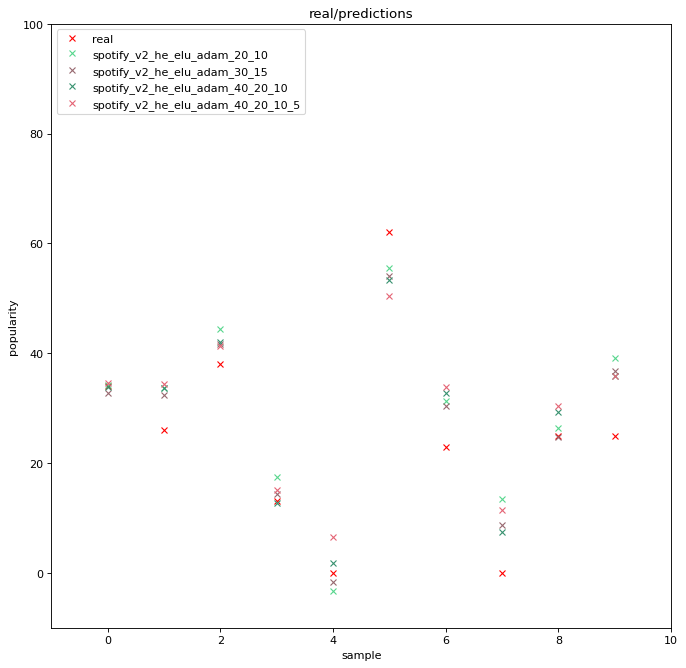

In [101]:
# plot real/pred chart
pred_dict = {"spotify_v2_he_elu_adam_20_10": spotify_v2_he_elu_adam_20_10_predictions,
             "spotify_v2_he_elu_adam_30_15": spotify_v2_he_elu_adam_30_15_predictions,
             "spotify_v2_he_elu_adam_40_20_10": spotify_v2_he_elu_adam_40_20_10_predictions,
             "spotify_v2_he_elu_adam_40_20_10_5": spotify_v2_he_elu_adam_40_20_10_5_predictions}
real_pred_plot = RealMultiPredPlotter(real=real, pred_dict=pred_dict)
real_pred_plot.plot()
